### This code here is to read the observational data of DMS from Vali et al 2019. It has also the a function to interpolate the coordinate for plotting the data in maps withput losing info due to the special coordinate system the observational data use.  

### library that are needed with the code filesystem for the bucket, where the data are stored.

In [1]:
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))


## DMS observational Data
listing the DMS observational Data (DMS concentration and their emission/flux)

In [2]:
s3.ls('escience2022/Antoine/Satellite_Arctic_DMS')

['escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2003_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2004_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2005_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2006_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2007_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2008_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2009_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2011_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2012_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2013_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2014_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2015_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2016_8D_28km.nc',
 'esci

## Open files

In [3]:
#### single file
# file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc'
# ds = xr.open_dataset(s3.open(file))

### multiple files
s3files = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A*_8D_28km.nc'
remote_files = s3.glob(s3files)
fileset = [s3.open(file) for file in remote_files]
ds = xr.open_mfdataset(fileset, combine='by_coords')

ds

<xarray.Dataset>
Dimensions:      (year: 14, pixel: 96668, period: 46)
Coordinates:
  * year         (year) float64 2.003e+03 2.004e+03 ... 2.015e+03 2.016e+03
Dimensions without coordinates: pixel, period
Data variables:
    longitude    (year, pixel) float64 dask.array<chunksize=(1, 96668), meta=np.ndarray>
    latitude     (year, pixel) float64 dask.array<chunksize=(1, 96668), meta=np.ndarray>
    startjulday  (year, period) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    endjulday    (year, period) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    dms          (period, year, pixel) float64 dask.array<chunksize=(46, 1, 96668), meta=np.ndarray>

## Interpolation on regular grid function

This function is used ONLY for plotting in maps. For time series, one should use the original data and this interpolation function SHOULD NOT be used.

In [4]:
from scipy.interpolate import griddata

def interGali(ds,var):
    '''
        Interploting data on a regular lat,lon grid
        grid is built from latitudes and the longitudes on the lowest latitude
        Input : 
            ds : xarray dataset with latitude, longitude and variable "var" to be interpolated. 
                var, lat,long must be 1d (ie. not depend on time)
            var : string name of variable
        Returns a xarray dataArray with the gridded variable and lat lon as coords
    '''
    
    # sorting according to latitudes
    lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values]).sortlevel(level=0)[0] 
    # get longitudes of lowest latitude
    lowlat = lalo.values[0][0]
    lon1d = np.array([x[1] for x in lalo.values if x[0]==lowlat])
    # get latitudes
    lat1d = np.unique(ds.latitude.values)
    # Building regular grid of lat and lon
    lon, lat = np.meshgrid(lon1d,lat1d)

    # interpolation
    var_gridded =griddata(
            (ds.longitude.values, ds.latitude.values), #points
            ds[var].values, #data
            (lon, lat), #grid on which to interpolate
            method='nearest')
    
    return  xr.DataArray(
        var_gridded,
        dims=("lat","lon"),
        coords={
            "lat": lat1d,
            "lon": lon1d
        }
    )


In [5]:
dms_gridded = interGali(ds.sel(year=2011).isel(period=20), 'dms')
dms_gridded

<xarray.DataArray (lat: 180, lon: 1016)>
array([[2.14019965, 2.67585512, 2.97959834, ..., 2.51319014, 2.15987421,
        2.0883398 ],
       [2.2285881 , 2.15084394, 2.62837003, ..., 2.2041256 , 2.53877417,
        2.32902023],
       [2.33760172, 2.33502616, 2.12421132, ..., 2.04021394, 2.33804344,
        2.53232563],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 45.12 45.38 45.62 45.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float64 -179.8 -179.5 -179.1 -178.8 ... 179.1 179.5 179.8

## Plots

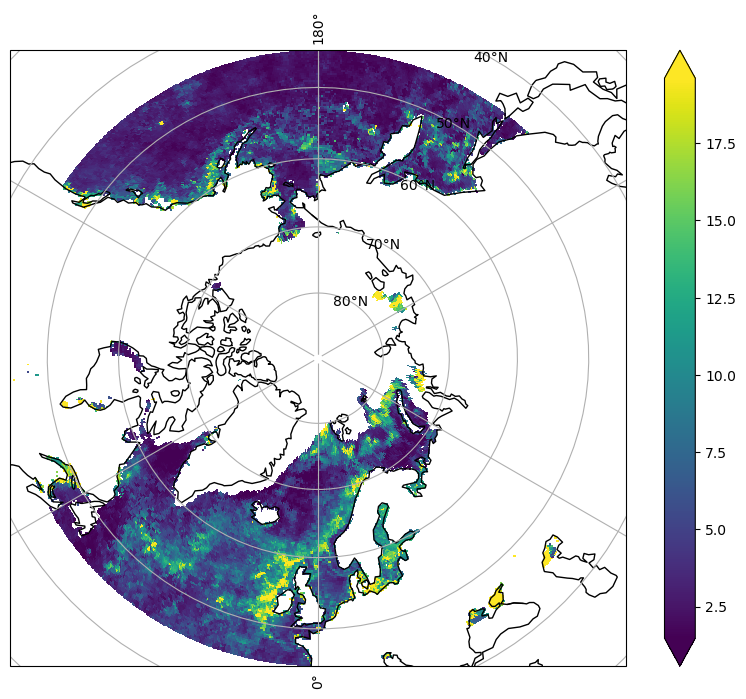

In [6]:

fig, ax = plt.subplots(figsize=(8,8),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()}
                       # subplot_kw={'projection':ccrs.PlateCarree()
                                  )

dms_gridded.plot.pcolormesh( 
    ax = ax,
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8},
    transform=ccrs.PlateCarree(),
    robust=True
)


ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()

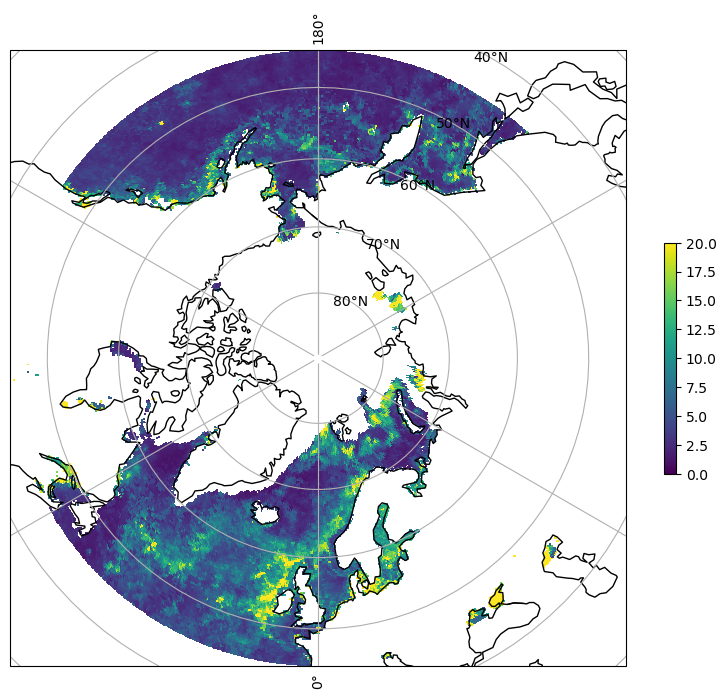

In [7]:
fig, ax = plt.subplots(figsize=(8,8),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()}
                       # subplot_kw={'projection':ccrs.PlateCarree()
                                  )

pl=ax.pcolormesh(dms_gridded.lon,dms_gridded.lat,dms_gridded,
    vmin=0,vmax=20,
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
        )
fig.colorbar(pl,shrink=0.3)
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()

In [25]:
dms_gridded_yr2015 = interGali(ds.sel(year=2015).isel(period=45), 'dms')
dms_gridded_yr2015

<xarray.DataArray (lat: 180, lon: 1016)>
array([[0.36136049, 0.39429258, 0.33734134, ..., 0.39222373, 0.3477552 ,
        0.33834029],
       [0.31583803, 0.43672793, 0.57477384, ..., 0.55198051, 0.32507944,
        0.29886812],
       [0.36314176, 0.31204159, 0.32640793, ..., 0.28478712, 0.36930835,
        0.28282726],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 45.12 45.38 45.62 45.88 ... 89.12 89.38 89.62 89.88
  * lon      (lon) float64 -179.8 -179.5 -179.1 -178.8 ... 179.1 179.5 179.8

## Rounding

In [9]:
##sorting according to latitudes
# lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values]).sortlevel(level=0)[0] 
## get longitudes of lowest latitude
# lowlat = lalo.values[0][0]
# lons = np.array([x[1] for x in lalo.values if x[0]==lowlat])
# lons.size

1016

In [ ]:
# ## round longitudes to those of lowest latitude
# def find_nearest(array, value):
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]

# for ip in range(ds.pixel.size):
#     # if ip%1002==0:
#         # print(ds['longitude'].values[ip] , find_nearest(lons,ds['longitude'].values[ip]) )
#     ds['longitude'][ip]= find_nearest(lons,ds['longitude'].values[ip])

In [6]:
np.unique(ds['longitude'].values).size

91637

In [3]:
#### change coordinate from pixel (1d) to lat lon (2d)

### DOES NOT WORK : grid is not structured and rounding longitude will lead to superposing pixels tw0 pixel on same point
# lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values.round()],names=["lat", "lon"])

lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values],names=["lat", "lon"])
# lalo.sortlevel(level=0)
##checking for duplicates
m = np.zeros_like(lalo, dtype=bool)
m[np.unique(lalo, return_index=True)[1]] = True
lalo[~m]

MultiIndex([], names=['lat', 'lon'])

In [ ]:
# 
ds=ds.assign_coords({ "pixel": lalo }).unstack("pixel")
ds#.sel(lat=45.125)

## Sin Projection

In [10]:
def sinProj(lat,lon):
    # x=lon*np.cos(lat*np.pi/180)
    # y=lat
    x=lon/np.cos(lat*np.pi/180)
    y=lat
    return x,y

ds['x'],ds['y'] = sinProj(ds.latitude,ds.longitude)
# ds
# np.unique(ds.x.values.round()).size


In [11]:
#### change coordinate from pixel (1d) to lat lon (2d)

yx = pd.MultiIndex.from_arrays([ds.y.values, ds.x.values.round()],names=["y", "x"])
# yx.sortlevel(level=1)

##checking for duplicates
# m = np.zeros_like(yx, dtype=bool)
# m[np.unique(yx, return_index=True)[1]] = True
# yx[~m]

In [12]:
ds=ds.assign_coords({ "pixel": yx }).unstack("pixel")
ds#.sel(lat=45.125)

<xarray.Dataset>
Dimensions:      (y: 180, x: 3319, year: 1, period: 46)
Coordinates:
  * y            (y) float64 45.12 45.38 45.62 45.88 ... 89.12 89.38 89.62 89.88
  * x            (x) float64 -5.5e+04 -2.445e+04 ... 2.445e+04 5.5e+04
  * year         (year) float64 2.01e+03
Dimensions without coordinates: period
Data variables:
    longitude    (y, x) float64 nan nan nan nan nan ... nan nan nan nan 120.0
    latitude     (y, x) float64 nan nan nan nan nan ... nan nan nan nan 89.88
    startjulday  (period) float64 1.0 9.0 17.0 25.0 ... 337.0 345.0 353.0 361.0
    endjulday    (period) float64 8.0 16.0 24.0 32.0 ... 344.0 352.0 360.0 365.0
    dms          (period, year, y, x) float64 nan nan nan nan ... nan nan nan